Option Contracts
---

`Option Contracts` can be a bit complicated to understand. They are derived from an underlying asset, for example a stock, and represent the right to sell or purchase some quantity of that asset (in general, 100 shares of the underlying stock).

There are 'put' contracts and 'call' contracts --> the right to sell shares, and the right to purchase shares, respectively.

Those contracts can be sold ('written'), or purchased. For example, if I bought a 'put', I would then own the right to **sell 100 shares** at the listed strike price. If I bought a 'call', I would then have the right to **purchase 100 shares** at the given strike price. 

Conversely, if I sold a 'put', I would be selling the right for someone to sell me 100 shares at the strike price. If I sold a 'call', I would be selling the right for someone to themselves purchase 100 shares at the strike price. 

#### Extrinsic Value
All contracts have a premium -- an up-front cost that is paid once. This sale price varies over time, depending on the options markets. 

#### Intrinsic Value
Each contract also has an implied value, which is derived from the price of the underlying asset.

A contract must be "in the money" at expiry in order for the contract to be executed. This means that:

- a `put` is in the money if the stock price is BELOW the strike price
- a `call` is in the money if the stock price is ABOVE the strike price

The intrinsic value, then, could be said to be the *difference* between the market price of the asset, and the strike price of the contract.

If the contract is *in the money*, the owner of the contract has the right to purchase 100 shares of the underlying stock at the set strike price, and reap the benefits of that transaction -- 100 * the difference between the market price and the strike price.

In order to effectively calculate the returns/losses on an options contract, we must take into account this transaction of shares. 

We can't calculate the returns directly, because we need to purchase "margin shares" in the case of a written call or bought put. We should have some sort of container for our `Holdings`.

To accomplish this task, I propose the following structure:
    
    - a `Portfolio` class which can 'hold' shares of different stocks. This layer could have portfolio optimization functionality. Each Portfolio could rely on a different trading strategy, ie. momentum, growth, etc.
    
    - a stock-specific `Holdings` class which handles the acquisition or sale of all shares of that stock inside the Portfolio. This layer contains information about the underlying stock -- past statistics/trends, buy or sell signals, sector, etc. 
    
    - an `OptionContract` class which handles the value logic of an options contract, given the current share price (held in Holdings).

Let's start at the bottom -->

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,3)
plt.style.use('ggplot')

# Portfolio object


In [11]:
class Portfolio():
    '''A container for Holdings objects, optimization
    
        accepts:
        name : the name of the portfolio/strategy
        init_capital : the capital available for the strategy.
        
    '''

    def __init__(self, name='Portfolio', init_capital=0):
        self.free_capital = init_capital
        self.name = name
        self.holdings = [] # list of Holdings objects
        self._value = init_capital # initialize the value as equal to the capital allocation.
        
        
        # 
    @property
    def tickers(self):
        return [x.ticker for x in self.holdings] 
    @property
    def prices(self):
        return [x.value for x in self.holdings]
    @property
    def num_shares(self):
        return [x.shares for x in self.holdings]
    
    @property
    def value(self):
        self._value = sum([x.value for x in self.holdings]) + self.free_capital
        return self._value
        
    def transfer_funds(self, holdings_obj, amount):
        self.free_capital = self.free_capital - amount
        holdings_obj.capital = holdings_obj.capital + amount

We expect our Holdings objects to have:

.ticker, .capital, .value, and .shares methods.  This is a rudimentary architechture.

In [12]:
port = Portfolio('TECH', 5000)
port.value

5000

# Holdings object

In [13]:
class Holdings():
    '''
    loads relevant data about a given stock
    
    elegantly handles contract purchases
    
    container and functions for all assets related to a specific stock
    
    - allow purchasing/selling of the underlying stock
    - allow purchasing(and deletion?) of contracts
        - require margin shares for written calls; their value will decrease as market_price drops.
        - 'settle' any written puts by purchasing shares at strike, if in the money --> 

    
    accepts:
    ticker : valid yfinance ticker
    
    
    
    '''
    def __init__(self, ticker):
        
        self._ticker = ticker
        self.stock = yf.Ticker(ticker)
        self._market_price = self.stock.info['previousClose']
#         print(f'fetched data for {self._ticker}...', end="\r")             
        
        # container attributes
        self.capital = 0 # debit this when purchasing shares or contracts; 
                                # credit when writing contracts or selling shares
        self._shares = 0
        self.contracts = [] # to hold 'OptionContract' objects...
        
        self.option_dates = list(self.stock.options)
        self.option_date = 0 # zero-indexing into option_dates
        self.opt = self.stock.option_chain(self.option_dates[self.option_date]) # initialize at 0
        self.calls = self.opt.calls.copy()
        self.puts = self.opt.puts.copy()
               
    @property
    def ticker(self):
        return self._ticker

    @property
    def market_price(self):
        return self._market_price
    @market_price.setter
    def market_price(self, newprice):
        self._market_price = newprice
        
        # adjust the market price of contract objects
        for x in self.contracts:
            x.market_price = newprice # update the market_price for all contracts held, whenever market_price changes
    
    # capital
#     @property
#     def capital(self):
#         return self._capital
#     @capital.setter
#     def capital(self, value):
#         assert self._capital + value >= 0, 'capital less than 0'
#         self.capital = self._capital + value
        
        
    @property
    def intrinsic_value(self): # the worth of shares plus the worth of contracts, given a set market_price
        return round((self._shares * self._market_price) + sum([x.value for x in self.contracts]), 4)
 
    @property
    def shares(self):
        return self._shares
    @shares.setter
    def shares(self, newval): #newval IS self.shares, when assigning using +=
        assert newval >= 0, 'You cannot have negative share count'
        self._shares = newval
    

    @property
    def value(self):     
        return (self.intrinsic_value + self.capital)
    
    def buy_shares(self, num_shares):
        cost = num_shares * self.market_price # adjust capital based on current market_price -->
        assert self.capital - cost >= 0, f"not enough to purchase {num_shares} of {self.ticker}"
        self.shares = self.shares + num_shares
        self.capital = self.capital - cost
        #         print(f'buying {num_shares} at {self.market_price} for {cost}')

    def sell_shares(self, num_shares):
        cost = num_shares * self.market_price
        assert self.shares - num_shares >= 0, f'cannot sell {num_shares}, only {self.shares} available.'
        self.shares = self.shares - num_shares
        self.capital = self.capital + cost
    #         print(f'selling {num_shares} at {self.market_price} for {cost}')


    def add_contract(self, contract):
        if (contract.writer == True) and (contract.call==True):
#             print('buying 100 shares to cover margin')
            self.buy_shares(100)
        self.contracts.append(contract)
        
    def resolve_contracts():
        prior_price = self.market_price # to reset after spread.
        for idx, contract in enumerate(self.contracts):
            self.contracts.pop(idx)
            
            if contract.inthemoney == True:
                
                if contract.writer == True: # sold contract 
                    
                    if contract.call == True:
                        self.market_price = contract._strike_price
                        self.sell_shares(100)
                    elif contract.call == False:
                        self.market_price = contract._strike_price
                        self.buy_shares(100)
                        
                elif contract.writer == False: # bought contract
                    
                    if contract.call == True:
                        self.market_price = contract._strike_price
                        self.buy_shares(100)
                    elif contract.call == False:
                        self.market_price = contract._strike_price
                        self.sell_shares(100)
                        
        self.market_price = prior_price

    def reset_object(self, capital=2500):
        'reset the extrinsic value, shares, and contracts of a Holdings object'
        self.shares = 0
        self.contracts.clear()
        self.capital = capital

        self._market_price = 8.94 #self.stock.info['previousClose']
    
    def __repr__(self):
        return str(self._ticker) + " Holdings"
    

### buying and selling shares

In [14]:
port_SLI = Holdings('SLI')

In [15]:
port.holdings.append(port_SLI)

In [16]:
port.transfer_funds(port_SLI, 2500)
port_SLI.buy_shares(100)

In [17]:
port.value

5000.0

In [18]:
port_SLI.value # this value is 

2500.0

# OptionContract object


In [3]:
class OptionContract(): 
    '''a stock-related asset, with an extrinsic and an intrinsic value\
    
    # 1 - extrinsic
     - the initial cost or credit
    # 2 - intrinsic
     - the intrinsic value represents the value of 100 shares at the strike price, if purchased, and in the money.
     - represents the negative value of 100 shares at the strike price, if sold, and in the money.
     - otherwise if not 'in the money', the intrinsic value is 0. 
    # 3 - functionality
     - redefines it's value (based on the state of the underlying Holdings object)
         - accepts mutations of its market_price value.
     - returns self.value, when called.
     
    '''
                                            # TODO: instead of market_price, pass the bound Holdings object.
                                            # implement a change to the holdings_object's value, and shares.
                                            # use .pop()?
                                            # also inherit the ticker!
                    
    def __init__(self, premium, strike_price, market_price, contract_size=100, writer=True, call=True):
        # calculating extrinsic value...
        self._writer = writer
        self.contract_size = contract_size
        self._extrinsic_value = None # initialize for conditional logic
        ### upon purchase or sale... change the static value of this contract:
        # determine initial credit or debit:
        if self._writer == True: # if sold
            self.extrinsic_value = (premium * contract_size)
        elif self._writer == False: # if purchased
            self.extrinsic_value = -1 * (premium * contract_size)
        #self._extrinsic_value now indicates the premium --> a negative value, if writer==False.
#         print(self._extrinsic_value)
        
        # reference variables
        self.premium = premium
        self.contract_size = contract_size
        

        # assign necessary variables
        self._strike_price = strike_price
        self._market_price = market_price     ## inherit from a Holdings.market_price?
        self._call = call # True, if the contract is a call. 
                         # False, if the contract is a put.
        
        # call properties to set them...(? i believe this is necessary.)
        self.inthemoney
        self.intrinsic_value
        
    # Intrinsic value logic... 
    # determine the intrinsic value. First, derive whether the contract is in the money.
    # This depends on what kind of contract it is; a call, or a put.
    #inthemoney
    @property 
    def inthemoney(self): 
        # for calls
        if (self.call == True) and self.market_price >= self._strike_price:
            self._inthemoney = True 
        if (self.call == True) and self.market_price < self._strike_price:
            self._inthemoney = False
        
        # for puts
        if (self.call == False) and self.market_price > self._strike_price:
            self._inthemoney = False
        if (self.call == False) and self.market_price <= self._strike_price:
            self._inthemoney = True
        return self._inthemoney
    
        # then calculate the intrinsic value, conditional on the inthemoney attribute
    # intrinsic_value
    @property
    def intrinsic_value(self):
        self.inthemoney # run the check(?)
        # if the contract is 'active'...
        if self.inthemoney == True:
            # actualize the implied shares..
            curr_val = (self.contract_size * self._market_price)
            # calculate the difference with the strike price
            strike_val = (self.contract_size * self._strike_price)
            delta = abs(strike_val - curr_val)
            
            if (self._call == True) and (self.writer==False):
                # you bought the call
                self._intrinsic_value = delta 
            if (self._call == False) and (self.writer==False):
                # you bought the put
                self._intrinsic_value = delta
         
            if (self._call == True) and (self.writer==True):
                # you sold the call --> you already had margin shares.
                self._intrinsic_value = -1 * delta
            if (self._call == False) and (self.writer==True):
                # you sold the put --> you have to buy the shares at that price!
                # for now, assume you would sell those shares immediately (at that loss). Later we can look at adding the shares.
                self._intrinsic_value =  -1 * delta
        else:
            return 0 
        return self._intrinsic_value  

    @intrinsic_value.setter
    def intrinsic_value(self, newval):
        self._intrinsic_value = newval
    
        # Attribute Getters/Setters
    # writer
    @property
    def writer(self):
        return self._writer
    # call
    @property
    def call(self):
        return self._call
    
    #extrinsic_value
    @property
    def extrinsic_value(self):
        return self._extrinsic_value
    @extrinsic_value.setter
    def extrinsic_value(self, newval):
        self._extrinsic_value = newval
    
    @property
    def market_price(self):
        return self._market_price
    @market_price.setter
    def market_price(self, newprice):
        self._market_price = newprice
        
    @property
    def value(self):
        return self._extrinsic_value + self.intrinsic_value
    
    def __repr__(self):
        return  str(('Written' if self._writer==True else 'Purchased')) \
                + str(self._strike_price) \
                + str(('Call' if self._call==True else 'Put'))

    def plot_contract(self, low, high, step, plot_me=True, return_me=False, alpha=1):
        curr_price = self.market_price
        values = []
        pricerange = np.arange(low, high, step)
        for price in pricerange:
            self.market_price = price
            values.append(self.value)
        
        if plot_me==True:
            plt.title(('Bought' if self.writer==False else 'Written', 'Call' if self.call==True else 'Put'))
            plt.scatter(pricerange, values, alpha=alpha)
        if return_me==True:
            return values
        
        self.market_price = curr_price

In [5]:
# this object is an independent entity
soldput = OptionContract(premium=2.12, strike_price=10, market_price=8.4, writer=True, call=False,) 

# this $212 put with a strike of $10 is currently worth $160 in hand -- it is in the money
# since we wrote the put, we stand to lose that money.
print(soldput.extrinsic_value, 
      soldput.intrinsic_value, 
      soldput.inthemoney)

212.0 -160.0 True


In [6]:
# this gives us our current value; $52.
soldput.value

52.0

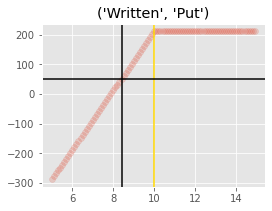

In [8]:
soldput.plot_contract(5, 15, 0.1, alpha=0.2) 
plt.axvline(soldput.market_price, color='black')
plt.axvline(soldput._strike_price, color='gold')
plt.axhline(52, color='black');

Since this is a sold (or written) put, we have agreed to purchase the underlying shares at the strike price. As the price of the asset rises towards the strike price, it's intrinsic value drops -- if it passes \$10, the contracts are worthless and we get to keep the full premium.

In [5]:
# if we change the market_price (until it's out of the money), let's see what happens -->
boughtput.market_price = 9.99
boughtput.value # note that this contract has the max value of $212 for any price $10 or above --> the written put is worthless
# Here we've lost 1 dollar from being a penny shy.

211.0

In [6]:
# instantiate a second instance of the object --> with the same arguments passed
boughtput2 = OptionContract(premium=2.12, strike_price=10, market_price=8.4, writer=True, call=False,)

boughtput.value, boughtput2.value # value is as described by the new call; it's a new instance of the object

(211.0, 52.0)

## Demonstration

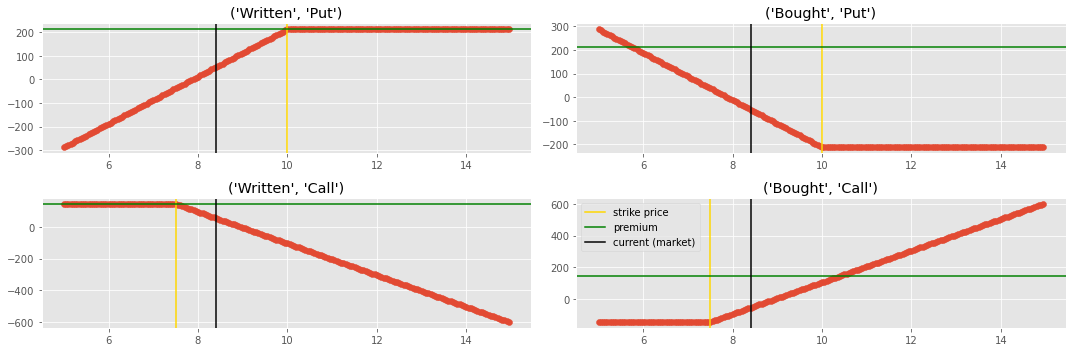

In [33]:
# creating a list of each type of contract for demonstration, then plotting

# ...boughtput is above...
soldput = OptionContract(premium=2.12, strike_price=10, market_price=8.4, writer=False, call=False,) # this $212 put with a strike of $10 is currently worth $160 in hand.

boughtcall = OptionContract(premium=1.45, strike_price=7.5, market_price=8.4, writer=True, call=True,) # this $212 put with a strike of $10 is currently worth $160 in hand.
soldcall= OptionContract(premium=1.45, strike_price=7.5, market_price=8.4, writer=False, call=True,) # this $212 put with a strike of $10 is currently worth $160 in hand.

contracts = [boughtput, soldput, boughtcall, soldcall]
low, high, step = 5, 15, 0.05
plt.subplots(2,2, figsize=(15,5))

for idx, c in enumerate(contracts):
    plt.subplot(2,2,idx+1)
    c.plot_contract(low, high, step )
    plt.axvline(c._strike_price, color='gold', label='strike price')
    plt.axhline((c.premium * 100), color='green', label='premium')
    plt.axvline(c.market_price, color='black', label='current (market)')
plt.legend()
#     plt.subplot(4,1,2)
#     soldput.plot_contract(low, high, step )
#     plt.subplot(4,1,3)
#     soldcall.plot_contract(low, high, step )
#     plt.subplot(4,1,4)
#     boughtcall.plot_contract(low, high, step )
plt.tight_layout()
plt.show()

## this function permits simply returning the values from the price-range assessment of the intrinsic/extrinsic valueq

As you can see above, each contract has a plateau which indicates its premium (we can only do better than the premium on contracts we've purchased). In the case of written calls or puts, we stand to lose the full difference between the strike price and the value of the stock; in the case of purchased calls or puts, we stand to gain the difference. This is offset by the cost of the contract, or premium.

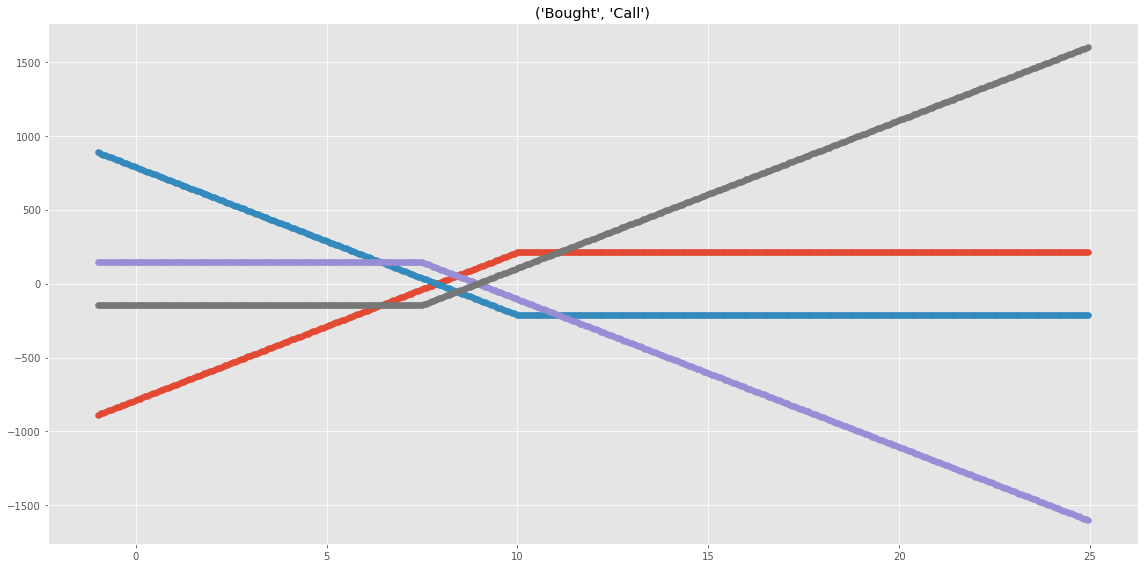

In [44]:
# for simplicity, only two strike prices and two different (therefore 2 equal) premiums...
contracts = [boughtput, soldput, boughtcall, soldcall]
low, high, step = -1, 25, 0.05
# plt.subplots(2,2, figsize=(15,5))
plt.figure(figsize=(16,8))
for idx, c in enumerate(contracts):
#     plt.subplot(2,2,idx+1)
    c.plot_contract(low, high, step )
#     plt.axvline(c._strike_price, color='gold', label='strike price')
#     plt.axhline((c.premium * 100), color='green', label='premium')
#     plt.axvline(c.market_price, color='black', label='current (market)')
# plt.legend()
#     plt.subplot(4,1,2)
#     soldput.plot_contract(low, high, step )
#     plt.subplot(4,1,3)
#     soldcall.plot_contract(low, high, step )
#     plt.subplot(4,1,4)
#     boughtcall.plot_contract(low, high, step )

plt.tight_layout()
plt.show()

# note that the function allows a negative market price?

Great. We could calculate the cost and value of bought margin shares easily, and match it with our contracts.

However, since we're here... let's see if we can create another class, which might represent all of our holdings related to one stock. I'd like to implement some kind of inheritance or polymorphism here (some common properties; for example to calculate the value at a given market price).

From the OptionContract object above, we have         
- extrinsic value
- intrinsic value
- contract_size (# implied shares)
- value --> a summation of the intrinsic and extrinsic value.

However, if we wanted to hold other information about the stock (in memory, or in some kind of filesystem), at some point we will need to parse some data (At very least, to find the market price!). Looking at this now, it might make more sense to update the OptionContract to hold a `ticker` attribute. However, below is the (former) 'super-class' of OptionContract...

One thing to consider would be to log the market_price (and a time value?) for purchases of shares and contracts. This would allow us to calculate returns (especially for shares), which is currently not implemented.

---

In [26]:
[h.add_contract(x) for x in all_options]
print(h.contracts, h.value)
h.reset_object()

[None, None, None, None]

In [73]:
# creating all_options list for testing..
boughtput=OptionContract(0.65, 7.5, 8.4, call=False, writer=False)
boughtcall=OptionContract(4, 5, 8.4, call=True, writer=False)
soldput=OptionContract(4, 5, 8.4, call=False, writer=True)
soldcall=OptionContract(4, 5, 8.4, call=True, writer=True)

all_options = [boughtput, boughtcall, soldput, soldcall]

In [74]:
def resolve_contracts(self):
    prior_price = self.market_price
    for idx, contract in enumerate(self.contracts):
        print(contract)
        self.contracts.pop(idx)
        if contract.inthemoney == True:
            if contract.writer == True:
                if contract.call == True:
                    self.market_price = contract._strike_price
                    self.sell_shares(100)
                elif contract.call == False:
                    self.market_price = contract._strike_price
                    self.buy_shares(100)
                self.market_price = prior_price
            elif contract.writer == False:
                if contract.call == True:
                    self.market_price = contract._strike_price
                    self.buy_shares(100)
                elif contract.call == False:
                    self.market_price = contract._strike_price
                    self.sell_shares(100)
        

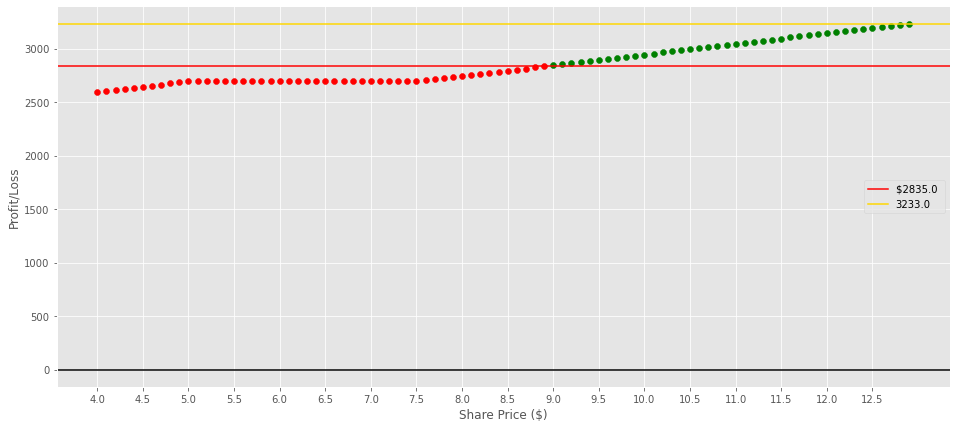

In [75]:
def plot_spread(holdings_obj):
    ''' return a meaningful representation of the calls/puts sheets held in the Holdings object'''
    h=holdings_obj
    _ = h.market_price # save and (eventually) restore the market_price from before the call.
    breakeven = holdings_obj.value # initial invested capital
    pricerange = np.arange(4,13,0.1) ### THIS NEEDS TO BE ABSTRACTED

    # container to check most profitable section. The plotted price.
    values = []
    top_pricepoint = 0
    top_val = 0
#     bot_pricepoint = 0

#     bot_val = breakeven
    for price in pricerange: # iterate through prices in pricerange
        h.market_price = price # changing the value of the underlying asset
        
        if h.value > top_val: # if the value of Holdings is greater than previous top_val..
            top_pricepoint, top_val = price, h.value
#         elif h.value < bot_val:
#             print(h.value)
#             bot_pricepoint, bot_val = price, h.value
            
            
        values.append(h.value)# regardless, append the current total value (versus price)
    h.market_price = _ # reset the market_price.
    
    plt.figure(figsize=(16,7))    
    plt.ylabel('Profit/Loss')
    plt.xlabel('Share Price ($)')

    for price, value in zip(pricerange, values):
        if value > breakeven:
            plt.scatter(price, value, c='green') ## profitable points noted in green
        else:
            plt.scatter(price, value, c='red') ## non-profitable points noted in red
            
    plt.axhline(breakeven, color='red', label=f'\${breakeven} ')

    
    # conditional 
    plt.xticks([x for x in pricerange[::5]])
#     plt.yticks([x for x in range(-3000, 3000, 200)])
    plt.axhline(0, color='black')
    plt.axhline(top_val, color='gold', label=f'{round(top_val, 1)}')
#     plt.axhline(bot_val, color='cyan', label=f'{round(bot_val, 1)}')

#     plt.axhspan(xmin=0, xmax=max(pricerange), ymin=0, ymax=top_val, alpha=0.2, color='gold')
#     plt.axhspan(xmin=0, xmax=max(pricerange), ymin=min(values), ymax=0, alpha=0.2, color='red')
    plt.legend()
#     plt.savefig('for guy.png')
    plt.show()

[h.add_contract(x) for x in all_options]
plot_spread(h)

### UTILIZING CALL AND PUT OPTION CHAINS

In [49]:
h = Holdings('SLI', 2500) 


In [ ]:
strikes, callprices, putprices = h.calls['strike'], h.calls['lastPrice'], h.puts['lastPrice']

In [69]:
df = pd.DataFrame([callprices, putprices], index=['calls', 'puts']).T
df.set_index(strikes, inplace=True)
df

,calls,puts
strike,,
2.5,6.10,0.02
5.0,4.00,0.05
7.5,1.75,0.39
10.0,0.54,1.72
12.5,0.14,4.00
15.0,0.05,5.25
17.5,0.05,7.70
20.0,0.05,14.00
22.5,0.05,17.20


## Plotting full spread of Options for a stock

This function calls for the yfinance object directly, but could easily be implemented in the class. It parses the available contract dates, calls the first value (contract_date == 0) and then finds the value of each type of contract at that market price. 

lowest and highest strike: 0 32.56912588524373


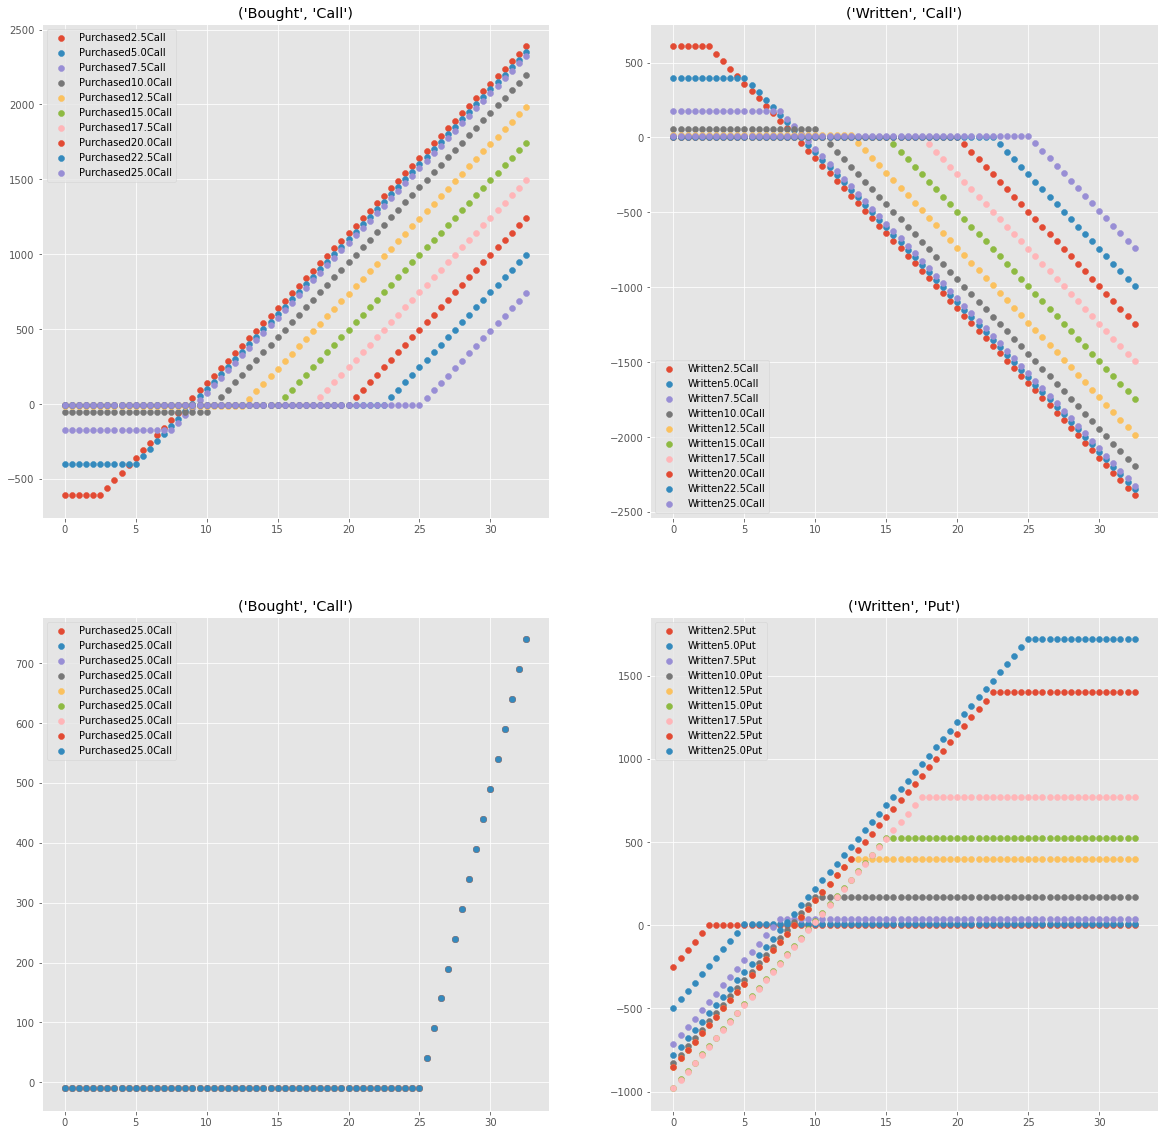

In [89]:
def plot_spreads(ticker, contract_date=0):
    
    stock = yf.Ticker(ticker)
    prev_close = stock.info['previousClose']
    options_dates = list(stock.options)
    mydate = options_dates[contract_date]  ### NEXT DATE IS 0-INDEXED VALUE FROM OPTIONS_DATES
    opt = stock.option_chain(mydate)
    # data available via: opt.calls, opt.puts
    calls = opt.calls
    puts = opt.puts
    

    std = calls['strike'].std()
    high = calls['strike'].max() + std
    low = (calls['strike'].min() - std)
    if low < 0:
        low=0
    print('lowest and highest strike:', low, high)
    
    ### CALLS###
    # bought calls
    prices = calls['lastPrice']
    strikes = calls['strike']
    bought_calls = []
    for price, strike in list(zip(prices, strikes)):
        boughtcall=OptionContract(price, strike, prev_close, call=True, writer=False)
        bought_calls.append(boughtcall)

    # sold calls
    sold_calls = []
    for price, strike in list(zip(prices, strikes)):
        soldcall=OptionContract(price, strike, prev_close, call=True, writer=True)
        sold_calls.append(soldcall)
        
        
    ### PUTS ###
    # bought puts
    prices = puts['lastPrice']
    strikes = puts['strike']
    bought_puts = []
    for price, strike in list(zip(prices, strikes)):
        boughtput=OptionContract(price, strike, prev_close, call=False, writer=False)
        bought_puts.append(boughtcall)


    # written puts
    sold_puts = []
    for price, strike in list(zip(prices, strikes)):
        soldput=OptionContract(price, strike, prev_close, call=False, writer=True)
        sold_puts.append(soldput)

    all_options = [bought_calls] + [sold_calls] + [bought_puts] + [sold_puts]

    plt.subplots(2, 2, figsize=(20, 20))
    for idx, lst in enumerate(all_options):
        plt.subplot(2,2 ,idx+1)
        labels = []
        for c in lst:
            c.plot_contract(low, high, 0.5)
            labels.append(c)
        plt.legend(labels=labels, loc='best')
#     plt.savefig('for guy.png', dpi=200)
    plt.show()
    
plot_spreads('SLI')

Note that the purchased call plot is broken because the `market_value` is shifting along with the intrinsic value of the contract... it's consistently representing it's value as the cost of the contract, because the value of shares is not included in the calls. Sold puts currently do not allocate shares --

## Another Example for testing...

In [95]:
# creating all_options list for testing..
boughtput=OptionContract(0.65, 7.5, 8.4, call=False, writer=False)
boughtcall=OptionContract(4, 5, 8.4, call=True, writer=False)
soldput=OptionContract(4, 5, 8.4, call=False, writer=True)
soldcall=OptionContract(4, 5, 8.4, call=True, writer=True)

all_options = [boughtput, boughtcall, soldput, soldcall]

## bought calls

In [107]:
#
h.reset_object()

boughtcall=OptionContract(3.4, 10, 8.87, call=True, writer=False)

# pay $340
h.add_contract(boughtcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 10
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares)
### This still needs work.

-340.0 2160.0 0
-340.0 2160.0 0
-340.0 2160.0 0


## sold puts

In [108]:
#
h.reset_object()

# soldcall=OptionContract(4.14, 5, 8.87, call=True, writer=True)
soldput=OptionContract(3.4, 10, 8.87, call=False, writer=True)

# make $340 --> currently paying 1.13
# h.add_contract(soldcall)
h.add_contract(soldput)
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 10
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares)


226.9999999999999 2727.0 0
340.0 2840.0 0
-160.0 2340.0 0


## sold calls

Purchased 100 shares for margin, at market price..

In [110]:
#
h.reset_object()
soldcall=OptionContract(1.4, 10, 8.87, call=True, writer=True)

# make $140 --> currently paying 0
# h.add_contract(soldcall)
h.add_contract(soldcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 8.87
h.market_price = 15
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 15 --> they want the shares.
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 5


140.0 2640.0 100
-360.0 2753.0 100
140.0 2253.0 100


## bought puts

In [113]:
#
h.reset_object()
soldcall=OptionContract(1.4, 10, 8.87, call=False, writer=False)

# make $140 --> currently paying 0
# h.add_contract(soldcall)
h.add_contract(soldcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 8.87
h.market_price = 15
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 15 --> they want the shares.
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 5


-26.999999999999886 2473.0 0
-140.0 2360.0 0
360.0 2860.0 0


### Final example 

In [ ]:
####JANKY

msft = Holdings('MSFT') ### JUNK

written_call = OptionContract(4, 300, msft)
written_put = OptionContract(4, 330, msft, call=False)
bought_put = OptionContract(4, 330, msft, writer=False, call=False)
bought_call = OptionContract(4, 330, msft, writer=False)

asset_list = [written_call, 
              written_put,
              bought_put, 
              bought_call]



[msft.contracts.append(x) for x in asset_list]

In [103]:
msft.__dict__

{'_ticker': 'MSFT',
 '_market_price': 323.8,
 '_shares': 0,
 'contracts': [WrittenMSFT300Call,
  WrittenMSFT330Put,
  SoldMSFT330Put,
  SoldMSFT330Call]}

In [105]:
print(type(bought_put))
isinstance(bought_put, Holdings)

<class '__main__.OptionContract'>


True